In [1]:
# !gdown --id 1QtAJsTjBOf3CnrTzTTqP-nPnHcTc2g9E
# !gdown --id 1vlqj4K04uZ7OUcb3LXpzR02I-RAsyToK
# !tar xf val.tar

In [2]:
# !pip install -q torch==1.6.0 torch-dct==0.1.5 timm foolbox

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook

import torch, torch_dct, timm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torchvision import transforms
import torchvision.datasets as dset
import foolbox as fb
import torchvision
import torch

In [4]:
PATH_TO_IMAGENET_VAL = "val"
IMAGE_SIZE = 224
BATCH_SIZE = 16 * torch.cuda.device_count()

In [5]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
bit = timm.create_model("resnetv2_50x3_bitm", pretrained=True)

if torch.cuda.device_count() > 1:
    num_devices = torch.cuda.device_count()
    vit = torch.nn.DataParallel(vit, device_ids=list(range(num_devices)))
    vit = vit.eval().to(DEVICE)
    bit = torch.nn.DataParallel(bit, device_ids=list(range(num_devices)))
    bit = bit.eval().to(DEVICE)

bounds = (-1, 1)
fmodel_vit = fb.PyTorchModel(vit, bounds=bounds)
fmodel_bit = fb.PyTorchModel(bit, bounds=bounds)

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_imagenet = dset.ImageFolder(root=PATH_TO_IMAGENET_VAL, transform=transform)
val_idx_subset = pickle.loads(open("random_indices_1000_imagenet_hmt.pkl", "rb").read())

val_sampler = torch.utils.data.SubsetRandomSampler(val_idx_subset)
val_imagenet_loader = torch.utils.data.DataLoader(dataset=val_imagenet, shuffle=False, 
                                 batch_size=BATCH_SIZE, 
                                 sampler=val_sampler, 
                                 num_workers=os.cpu_count(), 
                                 pin_memory=True if DEVICE=="cuda" else False)

print(f"Total ImageNet val size: {len(val_imagenet)}")
print(f"Total batches in the subset: {len(val_imagenet_loader)}")

Total ImageNet val size: 50000
Total batches in the subset: 16


In [7]:
attack = fb.attacks.L2DeepFoolAttack(steps=50)

In [8]:
def launch_deepfool(fmodel):
    deltas = []
    is_advs = []

    for (images, labels) in tqdm.notebook.tqdm(val_imagenet_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        raw, _, is_adv = attack(fmodel, images, labels, epsilons=1e-4)
        raw = raw.detach()
        is_adv = is_adv.detach()
        deltas.append((raw - images).cpu().numpy())
        is_advs.append(is_adv.cpu().numpy())
        
    return np.concatenate(deltas), np.concatenate(is_advs)

In [9]:
results_vit = launch_deepfool(fmodel_vit)
results_bit = launch_deepfool(fmodel_bit)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50 = torch.nn.DataParallel(resnet50, device_ids=list(range(num_devices)))
resnet50 = resnet50.eval().to(DEVICE)
fmodel_rn50 = fb.PyTorchModel(vit, bounds=bounds)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_imagenet = dset.ImageFolder(root=PATH_TO_IMAGENET_VAL, transform=transform)
val_imagenet_loader = torch.utils.data.DataLoader(dataset=val_imagenet, shuffle=False, 
             batch_size=BATCH_SIZE, 
             sampler=val_sampler, 
             num_workers=os.cpu_count(), 
             pin_memory=True if DEVICE=="cuda" else False)

deltas = []
is_advs = []

for (images, labels) in tqdm.notebook.tqdm(val_imagenet_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    raw, _, is_adv = attack(fmodel_rn50, images, labels, epsilons=1e-4)
    raw = raw.detach()
    is_adv = is_adv.detach()
    deltas.append((raw - images).cpu().numpy())
    is_advs.append(is_adv.cpu().numpy())
    
results_rn50 = (np.concatenate(deltas), np.concatenate(is_advs))

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
np.save("results_vit.npy", results_vit[0])
np.save("results_bit.npy", results_bit[0])
np.save("results_rn50.npy", results_rn50[0])

In [12]:
def compute_avg_energy(deltas):
    deltas_dct = torch_dct.dct_2d(torch.from_numpy(deltas)) # Change basis to DCT for example
    return 10*np.log10((deltas_dct ** 2).sum(dim=1).mean(dim=0).numpy()) # Compute average energy on DCT basis
    # log-transform is for better visualization

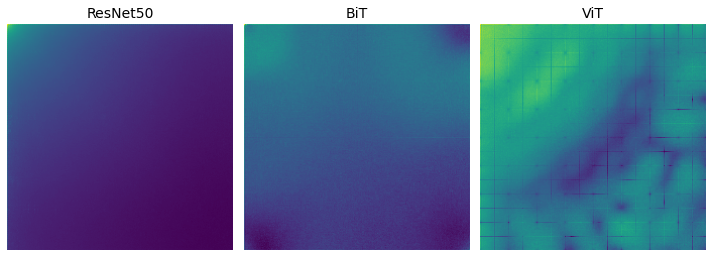

In [13]:
# The dims with the higher energy are those directions with the highest discriminative content
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 10))
[a.axis("off") for a in np.ravel(ax)] 

ax[0].imshow(compute_avg_energy(results_rn50[0]))
ax[1].imshow(compute_avg_energy(results_bit[0]))
ax[2].imshow(compute_avg_energy(results_vit[0]))

ax[0].set_title("ResNet50", fontsize=14)
ax[1].set_title("BiT", fontsize=14)
ax[2].set_title("ViT", fontsize=14)

fig.tight_layout()
fig.savefig("disc_regions.png", dpi=300, bbox_inches="tight")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


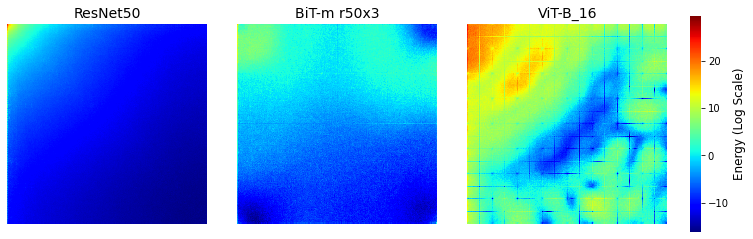

In [14]:
# https://stackoverflow.com/a/42712772/7636462

f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.get_shared_y_axes().join(ax2,ax3)

g1 = sns.heatmap(compute_avg_energy(results_rn50[0]), cmap="jet",cbar=False, ax=ax1)
g1.set(adjustable='box', aspect='equal')
g1.set_title("ResNet50", fontsize=14)
g1.axis("off")

g2 = sns.heatmap(compute_avg_energy(results_bit[0]), cmap="jet", cbar=False, ax=ax2)
g2.set(adjustable='box', aspect='equal')
g2.set_title("BiT-m r50x3", fontsize=14)
g2.axis("off")

cbar_ax = f.add_axes([0.99, .35, .015, .3])
g3 = sns.heatmap(compute_avg_energy(results_vit[0]), cmap="jet", ax=ax3, 
                 cbar_ax=cbar_ax,
                 cbar_kws={"label": "Energy (Log Scale)"})
cbar_ax.yaxis.label.set_size(12)
cbar_ax.set
g3.set(adjustable='box', aspect='equal')
g3.set_title("ViT B-16", fontsize=14)
g3.axis("off")

f.tight_layout(pad=3.0)
f.savefig("dct_heatmaps.png", dpi=300, bbox_inches="tight")